# Fake news tweet analysis on FakeNewsNet dataset

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pandarallel import pandarallel

from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

from utils import collect_tweets, collect_news
from models import Autoencoder

%matplotlib inline


[nltk_data] Downloading package stopwords to /home/jakob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jakob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jakob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
root_dir = "/media/jakob/DATA/Projects/FakeNewsNet/code/fakenewsnet_dataset/"

datasets = [
    "politifact",
    "gossipcop"
]

random_state = 42    # For reproducable random initialization 
pandarallel.initialize(nb_workers=3, use_memory_fs=True)  # initialization for pandas multiprocessing


INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
politifact_news = pd.read_json(collect_news(root_dir + datasets[0]))
politifact_news

,url,text,images,top_img,keywords,authors,canonical_link,title,meta_data,movies,publish_date,source,summary,truth
0,http://www.senate.gov/legislative/LIS/roll_cal...,Roll Call Vote 111th Congress - 1st Session\n\...,[http://www.senate.gov/resources/images/usFlag...,http://www.senate.gov/resources/images/us_sen.ico,[],[],,U.S. Senate: U.S. Senate Roll Call Votes 111th...,"{'viewport': 'width=device-width, initial-scal...",[],NaN,http://www.senate.gov,,real
1,http://www.politico.com/news/stories/0509/2241...,Barack Obama ended up in the middle of an unli...,"[data:image/gif;base64,R0lGODlhAQABAAAAACH5BAE...",http://s3-origin-images.politico.com/news/0905...,[],[Alexander Burns],https://www.politico.com/story/2009/05/trump-o...,Trump on Prejean: Same as Obama,"{'article': {'opinion': 'false'}, 'og': {'titl...",[],1.242120e+09,http://www.politico.com,,real
2,http://pollingreport.com/CongJob.htm,Follow @pollreport CONGRESS – Job Rating See a...,[http://pollingreport.com/images/logo3.gif],,[],[],,Congress: Job Ratings,"{'GENERATOR': 'Microsoft FrontPage 5.0', 'Micr...",[],NaN,http://pollingreport.com,,real
3,https://web.archive.org/web/20090514023215/htt...,House GOP Introduces Keep Terrorists Out of Am...,[https://web.archive.org/web/20090514023215im_...,https://web.archive.org/web/20090514023215im_/...,[],[],,House GOP Introduces Keep Terrorists Out of Am...,{},[],NaN,https://web.archive.org,,real
4,https://web.archive.org/web/20061116002411/htt...,'); //--> E-mail | Print | Comments | Request ...,[https://web.archive.org/web/20061116002411im_...,https://web.archive.org/web/20061116002411im_/...,[],[Robert Lenzner],,Is The End In Sight For Supermax?,{'description': 'Americas most secure and most...,[],1.145052e+09,https://web.archive.org,,real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,http://channel24news.com/2017/06/manager-kille...,10:30 pm last night police received a call abo...,[https://pranksocial.com/wp-content/uploads/20...,https://channel24news.com/wp-content/uploads/2...,[],[],https://channel24news.com/2017/06/manager-kill...,Manager killed 10 employees at checkers on 183...,"{'viewport': 'width=device-width, initial-scal...",[],1.498167e+09,http://channel24news.com,,fake
922,https://web.archive.org/web/20170629142109/htt...,"WASHINGTON, D.C. (AP) — At a press conference ...",[https://web.archive.org/web/20170629142109im_...,https://web.archive.org/web/20170629142109im_/...,[],"[Jimmy Rustling, Born At An Early Age, Jimmy R...",https://web.archive.org/web/20170629142109/htt...,Paul Ryan: “Donald Trump Plans To Resign From ...,"{'viewport': 'width=device-width, initial-scal...",[],1.498617e+09,https://web.archive.org,,fake
923,http://politicot.com/spicer-trump-legal-right-...,For full functionality of this site it is nece...,"[data:image/x-icon;,]","data:image/x-icon;,",[],[],,,"{'viewport': 'width=device-width,initial-scale...",[],NaN,http://politicot.com,,fake
924,https://web.archive.org/web/20170625021133/htt...,"As we promised, Freedom Crossroads has just le...",[https://web.archive.org/web/20170625021133im_...,https://web.archive.org/web/20170625021133im_/...,[],[],https://web.archive.org/web/20170625021133/htt...,BREAKING: The Democrat James Comey Has Been Ha...,"{'viewport': 'width=device-width, initial-scal...",[],1.498078e+09,https://web.archive.org,,fake


In [4]:
text_data = politifact_news[["text", "title", "truth"]]
del politifact_news # forget data so we don't run out of memory
text_data

,text,title,truth
0,Roll Call Vote 111th Congress - 1st Session\n\...,U.S. Senate: U.S. Senate Roll Call Votes 111th...,real
1,Barack Obama ended up in the middle of an unli...,Trump on Prejean: Same as Obama,real
2,Follow @pollreport CONGRESS – Job Rating See a...,Congress: Job Ratings,real
3,House GOP Introduces Keep Terrorists Out of Am...,House GOP Introduces Keep Terrorists Out of Am...,real
4,'); //--> E-mail | Print | Comments | Request ...,Is The End In Sight For Supermax?,real
...,...,...,...
921,10:30 pm last night police received a call abo...,Manager killed 10 employees at checkers on 183...,fake
922,"WASHINGTON, D.C. (AP) — At a press conference ...",Paul Ryan: “Donald Trump Plans To Resign From ...,fake
923,For full functionality of this site it is nece...,,fake
924,"As we promised, Freedom Crossroads has just le...",BREAKING: The Democrat James Comey Has Been Ha...,fake


In [5]:
text_data['truth'].value_counts()

real    540
fake    386
Name: truth, dtype: int64

In [6]:
def tokenize_clean(data, fields):
    punctuation = set('!"$%&\'’()*+,-./:;<=>?[\\]^_`{|}~•@#—–‘')
    punctuation.add("``")
    punctuation.add("''")
    punctuation.add("--")
    punctuation.add('”')
    # "..." also appears but carries semantic meaning so we leave it in

    data = data.apply(lambda x: x.astype(str).str.lower())
    data[fields] = data[fields].applymap(
        lambda x: re.sub(r"http\S+", "", x)) # remove links
    data[fields] = data[fields].applymap(word_tokenize)
    data[fields] = data[fields].applymap(set)
    data[fields] = data[fields].applymap(
        lambda x: x - set(stopwords.words('english')))
    data[fields] = data[fields].applymap(lambda x: x - punctuation)
    return data

In [7]:
text_data = tokenize_clean(text_data, ["text", "title"])
text_data

,text,title,truth
0,"{d-in, r-ga, d-va, lincoln, bond, clerk, april...","{senate, congress, u.s., votes, call, 111th, r...",real
1,"{judge, offense, composite, states, “, marriag...","{obama, trump, prejean}",real
2,"{8/2-17/21, 5/3/15, 6/14-18/12, 5/2-7/13, 11/9...","{job, ratings, congress}",real
3,"{legislature, transfer/release, boehner, presi...","{keep, act, gop, america, introduces, house, t...",real
4,"{leaders, real, youd, cost, justify, hopefull...","{end, sight, supermax}",real
...,...,...,...
921,"{received, fire, tons, pm, gardens.manager, 10...","{manager, 27ave, checkers, killed, 10, employe...",fake
922,"{leaders, real, interest, presidential, next, ...","{resign, within, donald, office, “, 30, trump,...",fake
923,"{browser, enable, web, instructions, full, jav...",{},fake
924,"{real, “, democrat, considering, accept, made,...","{breaking, james, affair, revealed, democrat, ...",fake


In [8]:
def stem_lemmatize(data, fields):
    p_stemmer = PorterStemmer()
    wordnet_lemmatizer = WordNetLemmatizer()
    data[fields] = data[fields].applymap(
        lambda x: list(map(lambda token: p_stemmer.stem(token), x)))
    data[fields] = data[fields].applymap(
        lambda x: list(map(lambda token: wordnet_lemmatizer.lemmatize(token), x)))
    return data

In [9]:
text_data = stem_lemmatize(text_data, ["text", "title"])
text_data

,text,title,truth
0,"[d-in, r-ga, d-va, lincoln, bond, clerk, april...","[senat, congress, u.s., vote, call, 111th, roll]",real
1,"[judg, offens, composit, state, “, marriag, po...","[obama, trump, prejean]",real
2,"[8/2-17/21, 5/3/15, 6/14-18/12, 5/2-7/13, 11/9...","[job, rate, congress]",real
3,"[legislatur, transfer/releas, boehner, preside...","[keep, act, gop, america, introduc, hous, terr...",real
4,"[leader, real, youd, cost, justifi, hope, pub...","[end, sight, supermax]",real
...,...,...,...
921,"[receiv, fire, ton, pm, gardens.manag, 10:30, ...","[manag, 27ave, checker, kill, 10, employe, 183st]",fake
922,"[leader, real, interest, presidenti, next, mad...","[resign, within, donald, offic, “, 30, trump, ...",fake
923,"[browser, enabl, web, instruct, full, javascri...",[],fake
924,"[real, “, democrat, consid, accept, made, hell...","[break, jame, affair, reveal, democrat, comey,...",fake


In [10]:
vectorizer = CountVectorizer(
    lowercase=False,
    preprocessor=lambda x: x,
    stop_words=None,
    tokenizer=lambda x: text_data["text"][int(x)]
)

embedding = vectorizer.fit_transform([str(i) for i in range(len(text_data["text"]))])
embedding


<926x29510 sparse matrix of type '<class 'numpy.int64'>'
	with 222079 stored elements in Compressed Sparse Row format>

In [11]:
def frequent_words(embedding, threshold=1):
    w_counts = embedding.sum(axis=0)
    words = pd.DataFrame(data=[(word, w_counts[0, i])
            for word, i in vectorizer.vocabulary_.items() if (w_counts[0, i] > threshold)], columns=['word', 'score'])
    words.sort_values(by=['score'], inplace=True, ascending=False)
    return words

In [12]:
words = frequent_words(embedding)
words

,word,score
787,say,594
448,work,587
103,state,571
402,make,553
629,use,541
...,...,...
7789,22:17:48,2
7790,22:30:18,2
7792,21:47:21,2
7794,22:06:26,2


In [13]:
pca = TruncatedSVD(n_components=2, random_state=random_state)
projection = pca.fit_transform(embedding)
projection.shape


(926, 2)

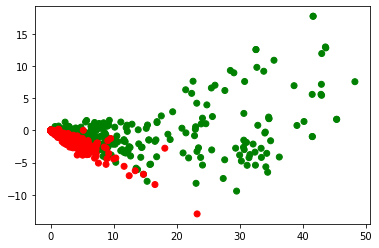

In [14]:
colors = ["green" if truth == "real" else "red" for truth in text_data["truth"]]
plt.scatter(projection[:, 0], projection[:, 1], c=colors)

In [15]:
text_data.iloc[np.where(np.fromiter(map(lambda x: x[0]>30 and x[1]>5, projection), dtype=bool))[0]]

,text,title,truth
59,"[accur, list, interest, presidenti, start, bre...","[associ, press, remark, luncheon, presid]",real
98,"[sail, reauthor, interest, break, engag, preve...","[obama, debat, go, head, mccain, last]",real
109,"[list, interest, energi, across-the-, engag, f...","[second, obama, debat, transcript, mccain]",real
119,"[energi, swift, break, push, stop, love, high-...","[colleg, remark, galesburg, economi, il, presi...",real
120,"[energi, swift, break, push, stop, love, high-...","[colleg, remark, galesburg, economi, il, presi...",real
122,"[sail, reauthor, interest, break, engag, preve...","[cpd, 2008, transcript, debat]",real
139,"[list, cafeteria, interest, start, whim, break...","[twitter, remark, hall, town, presid]",real
181,"[accur, list, add, interest, presidenti, denve...","[presidenti, wednesday, debat, transcript, 's]",real
182,"[accur, list, add, interest, presidenti, denve...","[presidenti, wednesday, debat, transcript, 's]",real
187,"[list, accept, revers, elimin, shortli, stop, ...","[issu, remark, gop, confer, hous, presid]",real


In [16]:
def word_truths(text_data, word, normalize=False):
    return text_data[text_data['text'].apply(
        lambda x: word in x)]['truth'].value_counts(normalize=normalize)


In [17]:
word_truths(text_data, 'transcript')


real    52
fake     3
Name: truth, dtype: int64

In [18]:
words['real_pct'] = words['word'].apply(lambda x: word_truths(
    text_data, x, normalize=True))['real']
words.sort_values(by='real_pct', ascending=False, inplace=True)
words

,word,score,real_pct
7794,22:06:26,2,1.0
6350,turbin,4,1.0
4508,event/speci,4,1.0
4663,24-25,2,1.0
7274,special-interest,4,1.0
...,...,...,...
11122,epipen,2,NaN
11119,pinterest,2,NaN
11117,officials.,2,NaN
11116,gorsuch,2,NaN


In [19]:
labels = [1 if truth == "real" else 2 for truth in text_data['truth']]

X_train, X_test, y_train, y_test = train_test_split(
    projection, labels, test_size=0.2, random_state=random_state)
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))

0.7956989247311828

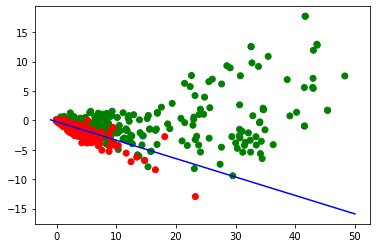

In [20]:
w = svm_classifier.coef_[0]
b = svm_classifier.intercept_[0]
x_points = np.linspace(-1, 50)
y_points = -(w[0] / w[1]) * x_points - b / w[1]  
plt.plot(x_points, y_points, c='b')
plt.scatter(projection[:, 0], projection[:, 1], c=colors)

In [21]:
intermediate_pca = TruncatedSVD(n_components=50, random_state=random_state)
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random', random_state=random_state)

intermediate_matrix = intermediate_pca.fit_transform(embedding)
projection = tsne.fit_transform(intermediate_matrix)
projection.shape

(926, 2)

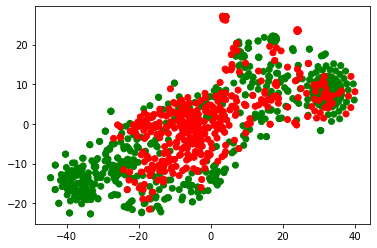

In [22]:
plt.scatter(projection[:, 0], projection[:, 1], c=colors)

In [23]:
tf_idf_transformer = TfidfTransformer()
embedding = tf_idf_transformer.fit_transform(embedding)
embedding

<926x29510 sparse matrix of type '<class 'numpy.float64'>'
	with 222079 stored elements in Compressed Sparse Row format>

In [24]:
words = frequent_words(embedding, threshold=0.1)
words


,word,score
600,use,17.490462
759,say,15.108446
100,state,14.837667
121,help,14.016200
373,support,13.806375
...,...,...
12095,faux,0.100189
9522,nonreligi,0.100137
6531,polish,0.100080
5902,elitist,0.100072


In [25]:
pca = TruncatedSVD(n_components=2, random_state=random_state)
projection = pca.fit_transform(embedding)
projection.shape

(926, 2)

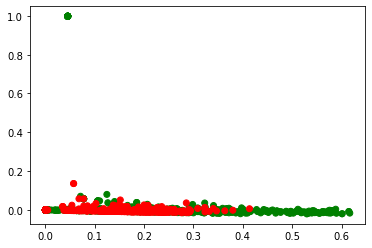

In [26]:
plt.scatter(projection[:, 0], projection[:, 1], c=colors)

In [27]:
text_data.iloc[np.where(np.fromiter(map(lambda x: x[0]>0.4, projection), dtype=bool))[0]]

,text,title,truth
12,"[interest, chief, capabl, condit, intact, co.,...","[brief, may, background, 2009, 31, gm, restruc...",real
14,"[list, start, root, door, repres, hello, mexic...","[auto, remark, american, resurg, industri, pre...",real
16,"[viewer, jersey, start, galleri, push, clean, ...","[kain, steel, transcript, week, 'thi]",real
19,"[accur, add, presidenti, start, nevada, push, ...","[boehner, hoyer, bill, transcript, week, gate,...",real
33,"[interest, start, engag, push, troubl, april, ...","[week, 'thi, transcript, biden]",real
...,...,...,...
502,"[pakistani, list, presidenti, jersey, start, r...","[holder, transcript, giuliani, week, 'thi]",real
519,"[viewer, interest, presidenti, bibl, start, en...",[transcript],real
526,"[accur, viewer, interest, presidenti, bibl, ju...","[democrat, presidenti, debat, transcript, part...",real
539,"[real, differ, interest, unilater, start, sure...","[halperin, mark]",real


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    projection, labels, test_size=0.2, random_state=random_state)
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)
accuracy_score(y_test, svm_classifier.predict(X_test))

0.6290322580645161

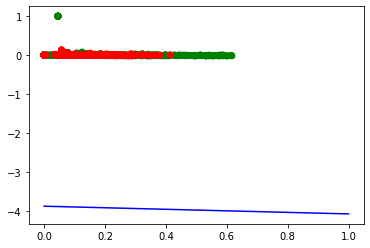

In [29]:
w = svm_classifier.coef_[0]
b = svm_classifier.intercept_[0]
x_points = np.linspace(0, 1)
y_points = -(w[0] / w[1]) * x_points - b / w[1]
plt.plot(x_points, y_points, c='b')
plt.scatter(projection[:, 0], projection[:, 1], c=colors)

In [30]:
intermediate_pca = TruncatedSVD(n_components=50, random_state=random_state)
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random', random_state=random_state)

intermediate_matrix = intermediate_pca.fit_transform(embedding)
projection = tsne.fit_transform(intermediate_matrix)
projection.shape

(926, 2)

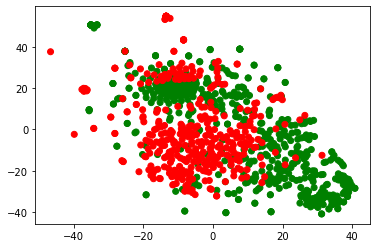

In [31]:
plt.scatter(projection[:, 0], projection[:, 1], c=colors)

In [32]:
del text_data 
del embedding
del projection

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

First, we load the tweets from our dataset to a Pandas DataFrame object for easier usage. We use a helper function ``collect_tweets`` that also adds a ``truth`` value to the tweet, depending on what kind of news it is talking about. Let's see how the tweets look like. 

In [33]:
politifact_tweets = pd.DataFrame(collect_tweets(root_dir + datasets[0]))
politifact_tweets

,author_id,conversation_id,created_at,entities,id,lang,source,text,truth,in_reply_to_user_id,referenced_tweets,attachments,geo,withheld
0,32497478,133032062784503808,2011-11-06T04:04:50.000Z,"{'annotations': [{'end': 5, 'normalized_text':...",133032062784503808,en,TweetDeck,Romney favored support of the federal assault ...,real,NaN,NaN,NaN,NaN,NaN
1,32497478,135231654175318017,2011-11-12T05:45:13.000Z,"{'annotations': [{'end': 5, 'normalized_text':...",135231654175318017,en,TweetDeck,Romney favored support of the federal assault ...,real,NaN,NaN,NaN,NaN,NaN
2,2234711,138610074829594624,2011-11-21T13:29:51.000Z,"{'annotations': [{'end': 96, 'normalized_text'...",138610074829594624,en,Silver Bird,#GOP #tcot RT @sjh2222: 2nd Amendment http://t...,real,NaN,NaN,NaN,NaN,NaN
3,32497478,139099903497469952,2011-11-22T21:56:16.000Z,"{'annotations': [{'end': 5, 'normalized_text':...",139099903497469952,en,TweetDeck,Romney favored support of the federal assault ...,real,NaN,NaN,NaN,NaN,NaN
4,83949216,139102215238459392,2011-11-22T22:05:27.000Z,"{'annotations': [{'end': 5, 'normalized_text':...",139102215238459392,en,TweetDeck,Romney favored support of the federal assault ...,real,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419526,39882689,790399441127649280,2016-10-24T03:48:06.000Z,"{'annotations': [{'end': 7, 'normalized_text':...",790399441127649280,en,Facebook,Bachmann: “White People Have Suffered More In ...,fake,NaN,NaN,NaN,NaN,NaN
419527,192726525,883382140729253894,2017-07-07T17:48:09.000Z,"{'annotations': [{'end': 7, 'normalized_text':...",883382140729253894,en,Twitter for iPhone,Bachmann: “White People Have Suffered More In ...,fake,NaN,NaN,NaN,NaN,NaN
419528,78663449,883414498576662529,2017-07-07T19:56:44.000Z,"{'annotations': [{'end': 7, 'normalized_text':...",883414498576662529,en,Facebook,Bachmann: “White People Have Suffered More In ...,fake,NaN,NaN,NaN,NaN,NaN
419529,133018525,883448484854202370,2017-07-07T22:11:47.000Z,"{'annotations': [{'end': 7, 'normalized_text':...",883448484854202370,en,Twitter Web Client,Bachmann: “White People Have Suffered More In ...,fake,NaN,NaN,NaN,NaN,NaN


In [34]:
# this cell takes roughly 10m to exectute
text_data = politifact_tweets[['text', 'truth']]

del politifact_tweets

text_data = tokenize_clean(text_data, ['text'])
text_data = stem_lemmatize(text_data, ['text'])
vectorizer = CountVectorizer(
    lowercase=False,
    preprocessor=lambda x: x,
    stop_words=None,
    tokenizer=lambda x: text_data["text"][int(x)]
)

embedding = vectorizer.fit_transform(
    [str(i) for i in range(len(text_data["text"]))])

embedding


<419531x287550 sparse matrix of type '<class 'numpy.int64'>'
	with 5812960 stored elements in Compressed Sparse Row format>

In [35]:
# w_counts = embedding.sum(axis=0)
# words = pd.DataFrame(data=[(word, w_counts[0, i])
#                            for word, i in vectorizer.vocabulary_.items() if (w_counts[0, i] > 1)], columns=['word', 'frequency'])
# words.sort_values(by=['frequency'], inplace=True, ascending=False)
# words

In [36]:
pca = TruncatedSVD(n_components=2, random_state=random_state)
projection = pca.fit_transform(embedding)
projection.shape

(419531, 2)

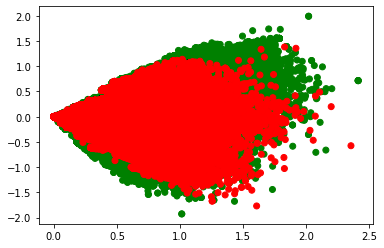

In [37]:
colors = ["green" if truth == "real" else "red" for truth in text_data["truth"]]
plt.scatter(projection[:, 0], projection[:, 1], c=colors)

We can see that the most important attributes of a tweet are ``text`` and ``user``. The ``place`` attribute is also very interesting, but is unfortunately not present in all tweets. Now, let's take a closer look at the ``user`` objects.

There are a number of interesting fields in the user object:
- ``verified`` (tells us whether the account is verified or not)
- ``followers_count``
- ``friends_count``
- ``favourites_count`` (the number of tweets the user has liked in their lifetime)
- ``statuses_count`` (the number of tweets and retweets the user has issued in their lifetime)

The above fields all have integer or boolean values, which makes them easy to work with in the context of data analysis. We will use these fields to try to visualize the users that tweeted real or fake news. Because we have 5 features, we will need some kind of dimensionality reduction to visualize them in 2D. 